In [36]:
import pickle
import pandas as pd
import numpy as np
import nrrd
import seaborn as sns

import umap
import umap.plot
import networkx as nx
import cs_umap_plot

from matplotlib import cm, colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output

import os

import time
import datetime

print(datetime.datetime.now())

2022-03-31 08:27:06.290506


In [2]:
def _get_extent(points):
    """Compute bounds on a space with appropriate padding"""
    min_x = np.min(points[:, 0])
    max_x = np.max(points[:, 0])
    min_y = np.min(points[:, 1])
    max_y = np.max(points[:, 1])

    extent = (
        np.round(min_x - 0.05 * (max_x - min_x)),
        np.round(max_x + 0.05 * (max_x - min_x)),
        np.round(min_y - 0.05 * (max_y - min_y)),
        np.round(max_y + 0.05 * (max_y - min_y)),
    )

    return extent

def umapNodes(
    umap_object,
    edge_bundling=None,
    edge_cmap="gray_r",
    show_points=False,
    labels=None,
    values=None,
    theme=None,
    cmap="Blues",
    color_key=None,
    color_key_cmap="Spectral",
    background="white",
    width=800,
    height=800,
):
    """Plot connectivity relationships of the underlying UMAP
    simplicial set data structure. Internally UMAP will make
    use of what can be viewed as a weighted graph. This graph
    can be plotted using the layout provided by UMAP as a
    potential diagnostic view of the embedding. Currently this only works
    for 2D embeddings. While there are many optional parameters
    to further control and tailor the plotting, you need only
    pass in the trained/fit umap model to get results. This plot
    utility will attempt to do the hard work of avoiding
    overplotting issues and provide options for plotting the
    points as well as using edge bundling for graph visualization.

    Parameters
    ----------
    umap_object: trained UMAP object
        A trained UMAP object that has a 2D embedding.

    edge_bundling: string or None (optional, default None)
        The edge bundling method to use. Currently supported
        are None or 'hammer'. See the datashader docs
        on graph visualization for more details.

    edge_cmap: string (default 'gray_r')
        The name of a matplotlib colormap to use for shading/
        coloring the edges of the connectivity graph. Note that
        the ``theme``, if specified, will override this.

    show_points: bool (optional False)
        Whether to display the points over top of the edge
        connectivity. Further options allow for coloring/
        shading the points accordingly.

    labels: array, shape (n_samples,) (optional, default None)
        An array of labels (assumed integer or categorical),
        one for each data sample.
        This will be used for coloring the points in
        the plot according to their label. Note that
        this option is mutually exclusive to the ``values``
        option.

    values: array, shape (n_samples,) (optional, default None)
        An array of values (assumed float or continuous),
        one for each sample.
        This will be used for coloring the points in
        the plot according to a colorscale associated
        to the total range of values. Note that this
        option is mutually exclusive to the ``labels``
        option.

    theme: string (optional, default None)
        A color theme to use for plotting. A small set of
        predefined themes are provided which have relatively
        good aesthetics. Available themes are:
           * 'blue'
           * 'red'
           * 'green'
           * 'inferno'
           * 'fire'
           * 'viridis'
           * 'darkblue'
           * 'darkred'
           * 'darkgreen'

    cmap: string (optional, default 'Blues')
        The name of a matplotlib colormap to use for coloring
        or shading points. If no labels or values are passed
        this will be used for shading points according to
        density (largely only of relevance for very large
        datasets). If values are passed this will be used for
        shading according the value. Note that if theme
        is passed then this value will be overridden by the
        corresponding option of the theme.

    color_key: dict or array, shape (n_categories) (optional, default None)
        A way to assign colors to categoricals. This can either be
        an explicit dict mapping labels to colors (as strings of form
        '#RRGGBB'), or an array like object providing one color for
        each distinct category being provided in ``labels``. Either
        way this mapping will be used to color points according to
        the label. Note that if theme
        is passed then this value will be overridden by the
        corresponding option of the theme.

    color_key_cmap: string (optional, default 'Spectral')
        The name of a matplotlib colormap to use for categorical coloring.
        If an explicit ``color_key`` is not given a color mapping for
        categories can be generated from the label list and selecting
        a matching list of colors from the given colormap. Note
        that if theme
        is passed then this value will be overridden by the
        corresponding option of the theme.

    background: string (optional, default 'white)
        The color of the background. Usually this will be either
        'white' or 'black', but any color name will work. Ideally
        one wants to match this appropriately to the colors being
        used for points etc. This is one of the things that themes
        handle for you. Note that if theme
        is passed then this value will be overridden by the
        corresponding option of the theme.

    width: int (optional, default 800)
        The desired width of the plot in pixels.

    height: int (optional, default 800)
        The desired height of the plot in pixels

    Returns
    -------
    result: matplotlib axis
        The result is a matplotlib axis with the relevant plot displayed.
        If you are using a notbooks and have ``%matplotlib inline`` set
        then this will simply display inline.
    """
    if theme is not None:
        cmap = _themes[theme]["cmap"]
        color_key_cmap = _themes[theme]["color_key_cmap"]
        edge_cmap = _themes[theme]["edge_cmap"]
        background = _themes[theme]["background"]

    points = umap_object.embedding_
    point_df = pd.DataFrame(points, columns=("x", "y", "z"))
    
    point_size = 4000.0 / np.sqrt(points.shape[0])
    if point_size > 1:
        px_size = int(np.round(point_size))
    else:
        px_size = 1

    if show_points:
        edge_how = "log"
    else:
        edge_how = "eq_hist"

    coo_graph = umap_object.graph_.tocoo()
    edge_df = pd.DataFrame(
        np.vstack([coo_graph.row, coo_graph.col, coo_graph.data]).T,
        columns=("source", "target", "weight"),
    )
    edge_df["source"] = edge_df.source.astype(np.int32)
    edge_df["target"] = edge_df.target.astype(np.int32)

    return point_df

def umapEdges(
    umap_object,
    edge_bundling=None,
    edge_cmap="gray_r",
    show_points=False,
    labels=None,
    values=None,
    theme=None,
    cmap="Blues",
    color_key=None,
    color_key_cmap="Spectral",
    background="white",
    width=800,
    height=800,
):
    """Plot connectivity relationships of the underlying UMAP
    simplicial set data structure. Internally UMAP will make
    use of what can be viewed as a weighted graph. This graph
    can be plotted using the layout provided by UMAP as a
    potential diagnostic view of the embedding. Currently this only works
    for 2D embeddings. While there are many optional parameters
    to further control and tailor the plotting, you need only
    pass in the trained/fit umap model to get results. This plot
    utility will attempt to do the hard work of avoiding
    overplotting issues and provide options for plotting the
    points as well as using edge bundling for graph visualization.

    Parameters
    ----------
    umap_object: trained UMAP object
        A trained UMAP object that has a 2D embedding.

    edge_bundling: string or None (optional, default None)
        The edge bundling method to use. Currently supported
        are None or 'hammer'. See the datashader docs
        on graph visualization for more details.

    edge_cmap: string (default 'gray_r')
        The name of a matplotlib colormap to use for shading/
        coloring the edges of the connectivity graph. Note that
        the ``theme``, if specified, will override this.

    show_points: bool (optional False)
        Whether to display the points over top of the edge
        connectivity. Further options allow for coloring/
        shading the points accordingly.

    labels: array, shape (n_samples,) (optional, default None)
        An array of labels (assumed integer or categorical),
        one for each data sample.
        This will be used for coloring the points in
        the plot according to their label. Note that
        this option is mutually exclusive to the ``values``
        option.

    values: array, shape (n_samples,) (optional, default None)
        An array of values (assumed float or continuous),
        one for each sample.
        This will be used for coloring the points in
        the plot according to a colorscale associated
        to the total range of values. Note that this
        option is mutually exclusive to the ``labels``
        option.

    theme: string (optional, default None)
        A color theme to use for plotting. A small set of
        predefined themes are provided which have relatively
        good aesthetics. Available themes are:
           * 'blue'
           * 'red'
           * 'green'
           * 'inferno'
           * 'fire'
           * 'viridis'
           * 'darkblue'
           * 'darkred'
           * 'darkgreen'

    cmap: string (optional, default 'Blues')
        The name of a matplotlib colormap to use for coloring
        or shading points. If no labels or values are passed
        this will be used for shading points according to
        density (largely only of relevance for very large
        datasets). If values are passed this will be used for
        shading according the value. Note that if theme
        is passed then this value will be overridden by the
        corresponding option of the theme.

    color_key: dict or array, shape (n_categories) (optional, default None)
        A way to assign colors to categoricals. This can either be
        an explicit dict mapping labels to colors (as strings of form
        '#RRGGBB'), or an array like object providing one color for
        each distinct category being provided in ``labels``. Either
        way this mapping will be used to color points according to
        the label. Note that if theme
        is passed then this value will be overridden by the
        corresponding option of the theme.

    color_key_cmap: string (optional, default 'Spectral')
        The name of a matplotlib colormap to use for categorical coloring.
        If an explicit ``color_key`` is not given a color mapping for
        categories can be generated from the label list and selecting
        a matching list of colors from the given colormap. Note
        that if theme
        is passed then this value will be overridden by the
        corresponding option of the theme.

    background: string (optional, default 'white)
        The color of the background. Usually this will be either
        'white' or 'black', but any color name will work. Ideally
        one wants to match this appropriately to the colors being
        used for points etc. This is one of the things that themes
        handle for you. Note that if theme
        is passed then this value will be overridden by the
        corresponding option of the theme.

    width: int (optional, default 800)
        The desired width of the plot in pixels.

    height: int (optional, default 800)
        The desired height of the plot in pixels

    Returns
    -------
    result: matplotlib axis
        The result is a matplotlib axis with the relevant plot displayed.
        If you are using a notbooks and have ``%matplotlib inline`` set
        then this will simply display inline.
    """
    if theme is not None:
        cmap = _themes[theme]["cmap"]
        color_key_cmap = _themes[theme]["color_key_cmap"]
        edge_cmap = _themes[theme]["edge_cmap"]
        background = _themes[theme]["background"]

    points = umap_object.embedding_
    point_df = pd.DataFrame(points, columns=("x", "y", "z"))
    
    point_size = 4000.0 / np.sqrt(points.shape[0])
    if point_size > 1:
        px_size = int(np.round(point_size))
    else:
        px_size = 1

    if show_points:
        edge_how = "log"
    else:
        edge_how = "eq_hist"

    coo_graph = umap_object.graph_.tocoo()
    edge_df = pd.DataFrame(
        np.vstack([coo_graph.row, coo_graph.col, coo_graph.data]).T,
        columns=("source", "target", "weight"),
    )
    edge_df["source"] = edge_df.source.astype(np.int32)
    edge_df["target"] = edge_df.target.astype(np.int32)

    return edge_df

In [3]:
path_data = 'data/d20220201/'

# INPUTS
fn_finalSave = path_data + 'featuresAndMeta_s20220215.p'\

# OUTPUTS
fn_edgelist = 'edgelist_s20220329.csv'
fn_nodelist = 'nodelist_s20220329.csv'

newcmp = ListedColormap(['Oranges_r', 'Blues'], name='OrangeBlue')

In [4]:
with open(fn_finalSave, "rb") as input_file:
    dict_data = pickle.load(input_file)

dict_data.keys()

dict_keys(['df_rawFeatures_training', 'df_rawFeatures_validation', 'dict_normalizationFactors', 'df_zscoreFeatures_training', 'df_zscoreFeatures_validation', 'df_metadata', 'umap_raw', 'umap_zscore'])

In [5]:
currFeatures = dict_data['df_zscoreFeatures_training'].append(dict_data['df_zscoreFeatures_validation'])
currFeatures

feature,original_shape_Elongation_liver,original_shape_Flatness_liver,original_shape_LeastAxisLength_liver,original_shape_MajorAxisLength_liver,original_shape_Maximum2DDiameterColumn_liver,original_shape_Maximum2DDiameterRow_liver,original_shape_Maximum2DDiameterSlice_liver,original_shape_Maximum3DDiameter_liver,original_shape_MeshVolume_liver,original_shape_MinorAxisLength_liver,...,wavelet-LLL_gldm_GrayLevelNonUniformity_spleen,wavelet-LLL_gldm_GrayLevelVariance_spleen,wavelet-LLL_gldm_HighGrayLevelEmphasis_spleen,wavelet-LLL_gldm_LargeDependenceEmphasis_spleen,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis_spleen,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis_spleen,wavelet-LLL_gldm_LowGrayLevelEmphasis_spleen,wavelet-LLL_gldm_SmallDependenceEmphasis_spleen,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis_spleen,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis_spleen
0001,-2.08464,-1.4094,-1.67395,-0.277974,-3.13043,0.046931,-1.37827,-0.592282,-1.63322,-2.27789,...,3.33023,-0.301376,0.249605,1.31814,0.948518,-0.187091,-0.540164,-1.07394,-0.335506,-0.893683
0002,-0.861254,-1.45606,-1.65062,0.325096,-0.741276,-0.453968,0.405009,0.914123,-0.919716,-0.552609,...,-0.423589,0.323547,0.0990684,-1.51575,-0.32846,-0.877887,-0.630411,1.36822,0.484536,-0.331403
0004,0.113737,0.897042,0.748043,-0.229533,0.034784,-0.0921265,-0.360733,-0.213945,0.105918,-0.0368242,...,-0.0761159,-0.995994,-1.58462,0.922069,-1.32654,2.07736,2.31224,-1.20646,-1.33002,1.28071
0005,0.7545,1.7327,0.5137,-1.49891,-0.48089,-0.635486,-1.41674,-0.981159,-0.640536,-0.587567,...,-0.791933,0.223778,-0.732027,0.0608133,-0.540647,0.146233,0.572548,0.243719,-0.66268,1.65199
0006,-0.195143,1.00767,0.63432,-0.462332,-0.328225,0.0902974,-1.1443,-0.181358,-0.199893,-0.557547,...,0.138933,-0.292259,0.156821,0.134431,0.309219,-0.378997,-0.507673,-0.368652,-0.101702,-0.593877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,-0.224354,-0.376536,0.4394,0.903926,1.64422,0.433486,1.61447,1.5657,0.577976,0.6759,...,-0.795262,0.217006,-0.515931,-0.800378,-0.813988,-0.323195,0.151564,0.812236,-0.217252,0.690555
1139,-0.559458,0.0783955,0.476775,0.362771,0.988455,-0.567589,0.192019,0.569543,0.359673,-0.148409,...,-0.742463,0.564779,-0.655648,-0.566214,-0.838911,-0.0350374,0.370864,0.377256,-0.418336,0.589878
1140,1.42107,2.87931,1.04539,-1.55831,-1.08936,-0.0812894,-1.35453,-1.59303,-0.345111,-0.381147,...,-0.642137,-0.876641,-0.867277,0.779894,-0.498728,0.894543,0.622828,-0.893567,-0.917389,0.204805
1141,0.215561,0.374686,0.277989,-0.18429,0.571245,-0.518877,0.0114744,0.207723,0.0621576,0.0712551,...,-0.528693,-0.708585,-0.774369,0.479544,-0.506952,0.573001,0.469622,-0.642717,-0.800958,0.271023


In [ ]:
dict_data['df_metadata']

In [7]:
fit = umap.UMAP(n_components=3,
                n_neighbors = 10,
                min_dist = 0.7)
embedding = fit.fit_transform(currFeatures)
mapper = fit.fit(currFeatures)

In [8]:
currColors = dict_data['df_metadata']['hvpg_corrected']
norm = colors.Normalize(vmin=0, vmax=66, clip=True)
colorMapper = cm.ScalarMappable(norm=norm, cmap=cm.RdYlBu)

currColors = pd.DataFrame()
currColors['hvpg_corrected'] = dict_data['df_metadata']['hvpg_corrected']
currColors['color'] = colorMapper.to_rgba(currColors['hvpg_corrected']).tolist()
test = pd.DataFrame(currColors['color'].to_list(), columns = ['r', 'g', 'b', 'a'], index=currColors.index)
currColors = pd.concat([currColors, test], axis=1)

/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [9]:
currColors

,hvpg_corrected,color,r,g,b,a
0001,11.0,"[0.9167243367935409, 0.3430219146482122, 0.223...",0.916724,0.343022,0.223991,1.0
0002,6.0,"[0.8239138792772011, 0.16978085351787775, 0.15...",0.823914,0.169781,0.152557,1.0
0004,6.0,"[0.8239138792772011, 0.16978085351787775, 0.15...",0.823914,0.169781,0.152557,1.0
0005,7.0,"[0.8498269896193772, 0.20230680507497117, 0.15...",0.849827,0.202307,0.159400,1.0
0006,9.0,"[0.8810457516339869, 0.2679738562091503, 0.189...",0.881046,0.267974,0.189542,1.0
...,...,...,...,...,...,...
1138,NaN,"[0.6470588235294118, 0.0, 0.14901960784313725,...",0.647059,0.000000,0.149020,1.0
1139,NaN,"[0.6470588235294118, 0.0, 0.14901960784313725,...",0.647059,0.000000,0.149020,1.0
1140,NaN,"[0.6470588235294118, 0.0, 0.14901960784313725,...",0.647059,0.000000,0.149020,1.0
1141,NaN,"[0.6470588235294118, 0.0, 0.14901960784313725,...",0.647059,0.000000,0.149020,1.0


In [28]:
currPos = umapNodes(mapper)
currPos.index = currColors.index
node_df = pd.concat([currPos, currColors], axis=1)
node_df['patient'] = node_df.index
node_df = node_df.reset_index()
node_df = node_df.drop(['hvpg_corrected', 'color', 'index'],axis=1)
node_df['r'] = np.floor(node_df['r']*255).astype(int)
node_df['g'] = np.floor(node_df['g']*255).astype(int)
node_df['b'] = np.floor(node_df['b']*255).astype(int)
node_df['a'] = np.floor(node_df['a']*100).astype(int)
node_df

node_df.to_csv(fn_nodelist, index=False,header=False)

In [11]:
edge_df = umapEdges(mapper)
edge_df = edge_df.drop(['weight'], axis=1)
edge_df.to_csv(fn_edgelist, index=False,header=False)

In [32]:
fit2d = umap.UMAP(n_components=2,
                n_neighbors = 10,
                min_dist = 0.7)
embedding2D = fit2d.fit_transform(currFeatures)
mapper2D = fit2d.fit(currFeatures)

/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


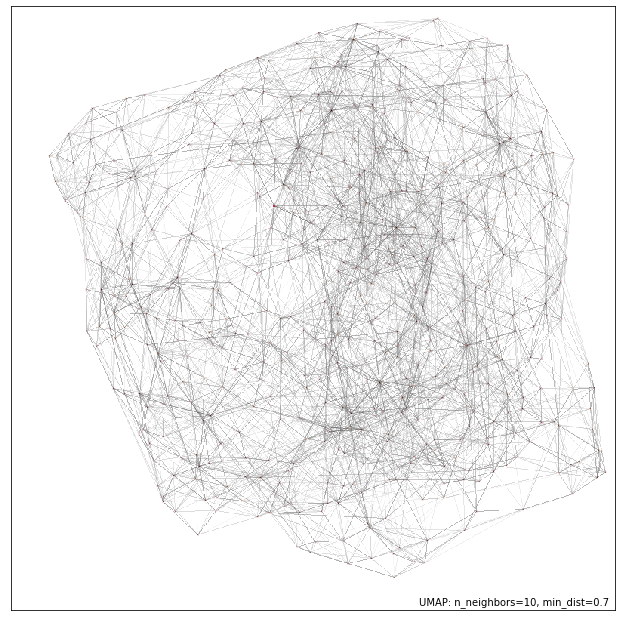

In [37]:
cs_umap_plot.connectivity(mapper2D, labels=dict_data['df_metadata']['hvpg_corrected'], show_points=True)